In [1]:
import cv2
from ultralytics import YOLO
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load models and mask
models = {
    'yolov8n': YOLO("/Users/macbook/Pengujian/videos_models/yolov8n.pt"),
    'yolov8s': YOLO("/Users/macbook/Pengujian/videos_models/yolov8s.pt"),
    'yolov8m': YOLO("/Users/macbook/Pengujian/videos_models/yolov8m.pt"),
    'yolov8l': YOLO("/Users/macbook/Pengujian/videos_models/yolov8l.pt"),
    'yolov8x': YOLO("/Users/macbook/Pengujian/videos_models/yolov8x.pt")
}
mask = cv2.imread("/Users/macbook/Pengujian/datasets_test/mask.jpg", cv2.IMREAD_GRAYSCALE)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: ramai
yolov8n: r

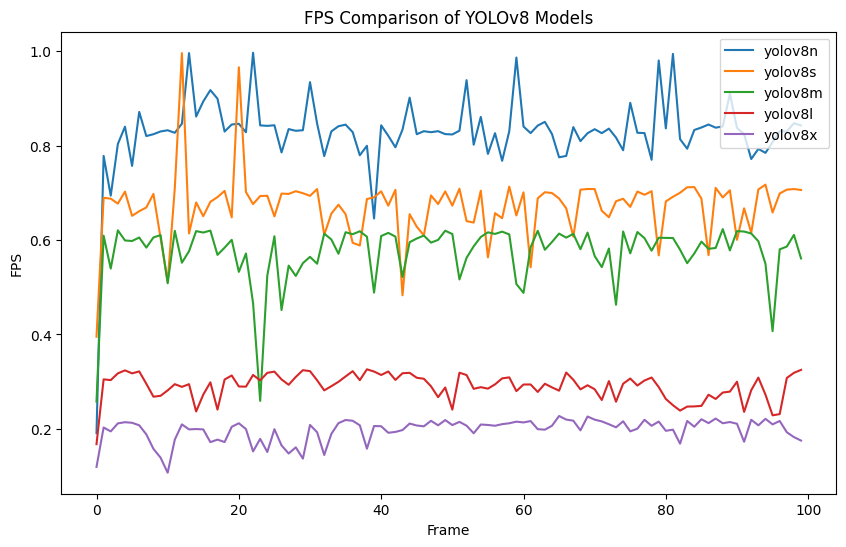

: 

In [3]:
# Function to draw bounding boxes
def draw_boxes(result, frame):
    blank = np.zeros(frame.shape, dtype=np.uint8)
    image = frame.copy()
    for box in result.boxes:
        x1, y1, x2, y2 = [round(x) for x in box.xyxy[0].tolist()]
        cls = int(box.cls[0])
        confidence = box.conf[0]

        # Assign colors and labels based on object class
        if cls == 0:  # car
            color = (0, 255, 0)  # Green
            label = "Car"
        elif cls == 1:  # motorcycle
            color = (0, 0, 255)  # Red
            label = "Motorcycle"
        elif cls == 2:  # person
            color = (255, 0, 0)  # Blue
            label = "Person"
        else:
            color = (255, 255, 255)  # White
            label = "Unknown"

        # Draw rectangle and label on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"{label} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.rectangle(blank, (x1, y1), (x2, y2), (255, 255, 255), -1)

    blank = cv2.bitwise_and(blank, blank, mask=mask)
    blank = cv2.cvtColor(blank, cv2.COLOR_BGR2GRAY)
    return blank, image

# Detection function
def detect(frame, model, threshold=30):
    masked = cv2.bitwise_and(frame, frame, mask=mask)
    result = model(masked, conf=0.25, verbose=False)
    area, image = draw_boxes(result[0], frame)
    percentage = round((np.sum(area) / np.sum(mask)) * 100, 2)
    label = "ramai" if percentage > threshold else "tidak ramai"
    return area, percentage, label

# Real-time CCTV video processing function for multiple models
def process_cctv(url, models, threshold=30, frame_count=100):
    vcap = cv2.VideoCapture(url)
    if not vcap.isOpened():
        print("Error: Could not open video stream.")
        return

    fps_data = {model_name: [] for model_name in models.keys()}

    for model_name, model in models.items():
        start_time = time.time()
        count = 0

        with open(f"/Users/macbook/Pengujian/cctv_result/{model_name}_result.csv", "w") as f:
            f.write("image,percentage,kondisi\n")

            while count < frame_count:
                ret, frame = vcap.read()
                if frame is None:
                    print("Frame is None")
                    break

                frame = cv2.resize(frame, (640, 384))
                area, percentage, kondisi = detect(frame, model, threshold)
                elapsed_time = time.time() - start_time

                if elapsed_time > 1:
                    start_time = time.time()
                    fps = 1 / elapsed_time
                    fps_data[model_name].append(fps)
                    
                    if percentage > 30:
                        f.write(f"{start_time},{percentage},ramai\n")
                        print(f"{model_name}: ramai")
                    else:
                        f.write(f"{start_time},{percentage},tidak ramai\n")
                        print(f"{model_name}: tidak ramai")
                    
                    cv2.imwrite(f"result/{start_time}_{model_name}_det.jpg", frame)
                    cv2.imwrite(f"result/{start_time}_{model_name}_area.jpg", area)
                    count += 1

                # Overlay text information on frame
                cv2.rectangle(frame, (0, 0), (200, 60), (0, 0, 0), -1)
                cv2.putText(frame, f"Area: {percentage}%", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
                cv2.putText(frame, f"FPS: {fps:.2f}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
                cv2.putText(frame, f"Kondisi: {kondisi}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

                cv2.imshow("Frame", frame)

                if cv2.waitKey(22) & 0xFF == ord('q'):
                    break

    vcap.release()
    cv2.destroyAllWindows()
    print("Video stop")
    
    # Save fps data to CSV
    fps_df = pd.DataFrame(fps_data)
    fps_df.to_csv("/Users/macbook/Pengujian/cctv_result/fps_comparison.csv", index=False)

    # Plot the FPS comparison
    plt.figure(figsize=(10, 6))
    for model_name in models.keys():
        plt.plot(fps_df[model_name], label=model_name)
    plt.xlabel("Frame")
    plt.ylabel("FPS")
    plt.title("FPS Comparison of YOLOv8 Models")
    plt.legend()
    plt.show()

# Run the real-time CCTV video processing function
url = "http://stream.cctv.malangkota.go.id/WebRTCApp/streams/134679292061611148844449.m3u8?token=null"
process_cctv(url, models, threshold=30, frame_count=100)